# Bibliotecas necesarias

In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_selector as Selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import seaborn as sns
from torch import nn
import pandas as pd
import numpy as np
import torch
import AC

# Clases y funciónes necesarias

In [2]:
class Classifier(nn.Module):
    
    def __init__(self, input_layer=40, hiden_layer=20, lr=0.01):
        # Initialise parent pythorch class
        super().__init__()
        # Define neural networks layers
        self.model = nn.Sequential(
            nn.Linear(input_layer, hiden_layer),
            nn.ReLU(), 
            nn.Linear(hiden_layer,1),
            nn.Sigmoid()
        )
        # Create loss function
        self.loss_function = nn.MSELoss()
        # Create optimise, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(),lr=lr)
        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # Calculate the opututs of the networks
        outputs = self.forward(inputs)
        #Calculate loss
        loss = self.loss_function(outputs,targets)
        # Zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
        
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

In [3]:
def get_data(data,target,drop):
    drop.append(target)
    # Select features and targets
    y = data[target]
    X = data.drop(columns=drop)
    # Encode the features
    X = column_transformer.transform(X)
    X = torch.from_numpy(X.toarray().astype(np.float32))
    y = torch.from_numpy(y.to_numpy().reshape(-1,1).astype(np.float32))
    
    return X, y

In [4]:
def metrics_classification(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred, labels=[0,1])
    fig, ax = AC.createFigures(figsize=(8,5))
    sns.heatmap(cm, annot=True, ax=ax, fmt=".0f", annot_kws=dict(size=16, weight='bold'), cbar=False);
    ax.set_xlabel('Predicted Label');
    ax.set_ylabel('True Label');
    report = classification_report(y_true, y_pred, target_names=['Negativo','Positivo'], digits=5)
    print(report)

# Se prepara el codificador de columnas

**Se crea el codificador de columnas**

In [5]:
# Transformer to encode categorical variables, and normalize numerical variables
column_transformer = ColumnTransformer([('categories',OneHotEncoder(handle_unknown='ignore'), 
                                         Selector(dtype_include=object))],
                                       remainder=MinMaxScaler())

**Se lee el conjunto de datos completo**

In [6]:
# Read the complete data set
dataset = pd.read_csv('all_atributes/covid_data_all_atributes.csv')
dataset = dataset.drop(columns=['CONFIRMADO','DEFUNCION','RESULTADO_LAB','RESULTADO_ANTIGENO'])

**Se ajusta el transformador**

In [7]:
column_transformer.fit(dataset)

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('categories',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14ff15d80>)])

**Se obtiene el tamaño de la capa de entrada**

In [8]:
# Size of the input layer
input_layer = column_transformer.transform(dataset.head(1)).shape[1]

**Se quita el conjunto de la memoria**

In [9]:
del dataset

# Seleccion y entrenamiento del modelo

**Se define la estructura de la red**

In [10]:
# Define the network to use
model = Classifier(input_layer,hiden_layer=20)

**Entrenamiento de la red**

In [11]:
train_file = 'all_atributes/all_atributes_train_data.csv'
chunksize = 1000
epochs = 5
# Train the model for every epoch
for i in range(epochs):
    print ('training epoch', i+1, "of", epochs)
    train_data = pd.read_csv(train_file, chunksize=chunksize)
    for data in train_data:
        X, y = get_data(data,target='CONFIRMADO',drop=['DEFUNCION','RESULTADO_LAB','RESULTADO_ANTIGENO'])
        # Train the model
        model.train(X, y)

training epoch 1 of 5
counter =  10000
training epoch 2 of 5
counter =  20000
training epoch 3 of 5
counter =  30000
training epoch 4 of 5
counter =  40000
training epoch 5 of 5
counter =  50000


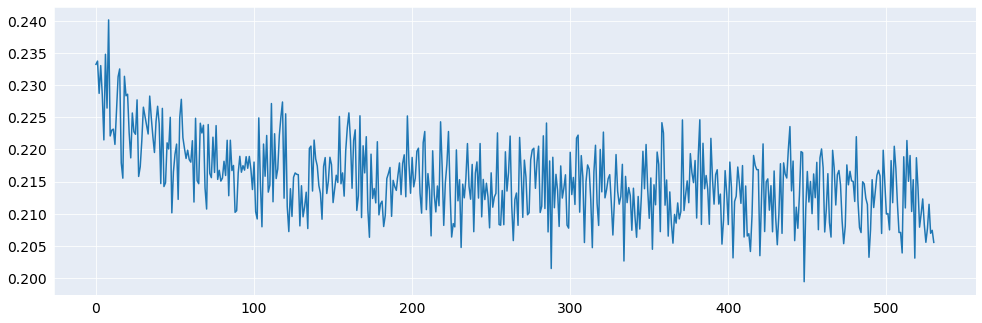

In [12]:
fig, ax = AC.createFigures(figsize=(16,5))
ax.plot(model.progress);

# Métricas de desempeño conjunto de entrenamiento

              precision    recall  f1-score   support

    Negativo    0.67580   0.89878   0.77150   6714224
    Positivo    0.59953   0.26004   0.36274   3912332

    accuracy                        0.66362  10626556
   macro avg    0.63766   0.57941   0.56712  10626556
weighted avg    0.64772   0.66362   0.62101  10626556



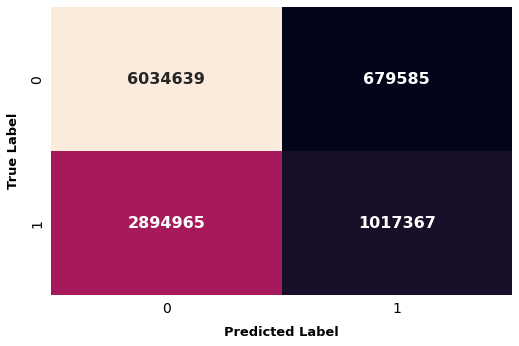

In [13]:
y_true = []
y_pred = []

for data in pd.read_csv(train_file, chunksize=1000):
    X, y = get_data(data,target='CONFIRMADO',drop=['DEFUNCION','RESULTADO_LAB','RESULTADO_ANTIGENO'])
    y_true.append(y)
    pred = model.forward(X)
    pred = np.where(pred>=0.5,1,0)
    y_pred.append(pred)
    
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

metrics_classification(y_true,y_pred)
del y_true, y_pred

# Métricas de desempeño conjunto de pruebas

In [14]:
test_file = 'all_atributes/all_atributes_test_data.csv'

              precision    recall  f1-score   support

    Negativo    0.67573   0.89896   0.77152   2877265
    Positivo    0.59981   0.25983   0.36259   1676974

    accuracy                        0.66362   4554239
   macro avg    0.63777   0.57940   0.56706   4554239
weighted avg    0.64778   0.66362   0.62095   4554239



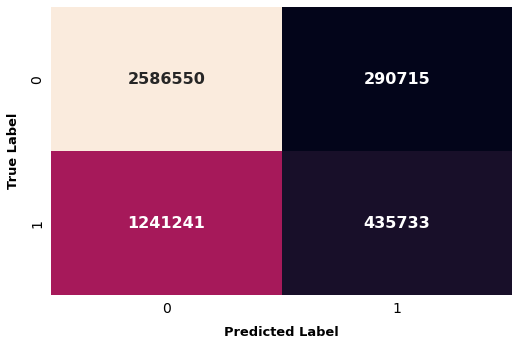

In [15]:
y_true = []
y_pred = []

for data in pd.read_csv(test_file, chunksize=1000):
    X, y = get_data(data,target='CONFIRMADO',drop=['DEFUNCION','RESULTADO_LAB','RESULTADO_ANTIGENO'])
    y_true.append(y)
    pred = model.forward(X)
    pred = np.where(pred>=0.5,1,0)
    y_pred.append(pred)
    
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

metrics_classification(y_true,y_pred)
del y_true, y_pred

In [16]:
dataset = pd.read_csv('all_atributes/covid_data_all_atributes.csv')

In [19]:
dataset.CONFIRMADO.value_counts()

0    9591489
1    5589306
Name: CONFIRMADO, dtype: int64

In [22]:
dataset.CONFIRMADO.value_counts()/dataset.CONFIRMADO.size

0    0.631817
1    0.368183
Name: CONFIRMADO, dtype: float64